# Preferential Attachment Model

### Libraries

In [2]:
## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
color_map = ["steelblue"]

### Supporting Functions

In [3]:
## supporting functions
from support.preprocessing import sort_adjacency, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single, generate_manifold, generate_topol_manifold, generate_topol_manifold
from support.param_generating import generate_param_graph_manifold, generate_param_topol_manifold
from support.latent_space import vis2D, visDistr

## import model
from models.VAE import VAE

Using TensorFlow backend.


## Loading and Preprocessing Network Data

### Loading Network Data

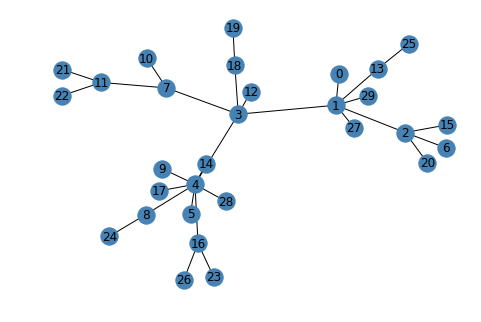

In [4]:
def get_graph(n,e,draw): 
    
    # n nodes
    # e Number of edges to attach from a new node to existing nodes
    
    g = random_graphs.barabasi_albert_graph(n, e, seed=None)

    if draw:
        nx.draw(g, node_color = color_map, with_labels = True)
        plt.show()
    
    return g

g = get_graph(n = 30, e = 1, draw = True)

# Generating Training Data

In [5]:
def generate_data(dataArgs): 
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], diag_offset = dataArgs["diag_offset"])))

    ## Ground Truth Labels ______________________________

    T = list()
    T_array = np.zeros((dataArgs["n_graphs"],2))

    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):

        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(2, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

        e = random.randint(1, max(1, n - 1)) # generate number of nodes n between 1 and n_max and
        g = get_graph(n, e, draw = False)

        g, a = sort_adjacency(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])


        ## Build Data Arrays___________________________________________________

        G[i] = a_transformed

        t = dict()
        t["n"] = n
        t["e"] = e

        T_array[i] = [n,e]
        T.append(t)



    ## Input and Output Size ___________________________________________________________

    T, input_shape, output_shape = prepare_in_out(T, dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]))
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale parameters in T_array for smoother training
    scaler = MinMaxScaler()
    scaler.fit(T_array)
    T_array = scaler.transform(T_array)
    
    return G,T,T_array,input_shape,output_shape,scaler

    
dataArgs = {"n_graphs": 1000, "n_max": 24, "fix_n": False, "diag_offset": 0, "diag_value": 1, "clip": True}  #"diag_offset" - 1 == full adjacency
G, T, T_array, input_shape, output_shape,scaler = generate_data(dataArgs)


input_shape: (300,) , output_shape: 300


# beta-VAE (MLP, 2D_Conv)

## Build and Train Model

In [7]:
# network parameters
modelArgs = {"nn_architecture": "mlp", "param_loss": True, "latent_dim": 2, "growth_param": T_array.shape[1], "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape}
trainArgs = {"beta": 2, "loss": "binary_crossentropy", "weights": "train", "early_stop": 1, "batch_size": 4, "epochs": 50, "data_split": 0.1}

vae = VAE(modelArgs, trainArgs, G, T_array)

models = vae.model 
data = vae.data

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 300)          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          38528       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           8256        dense_7[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            130         dense_8[0][0]                    
__________________________________________________________________________________________________
z_log_var 

# Latent Space Analysis

# Encoder

# Iterate through single data dimension and oberseve single latent space dimension  

Mutual Information Gap: 0.5895513143405684


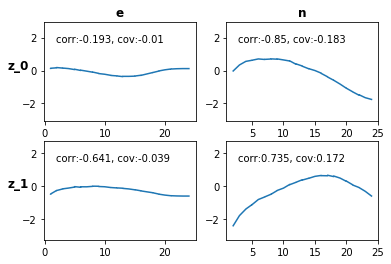

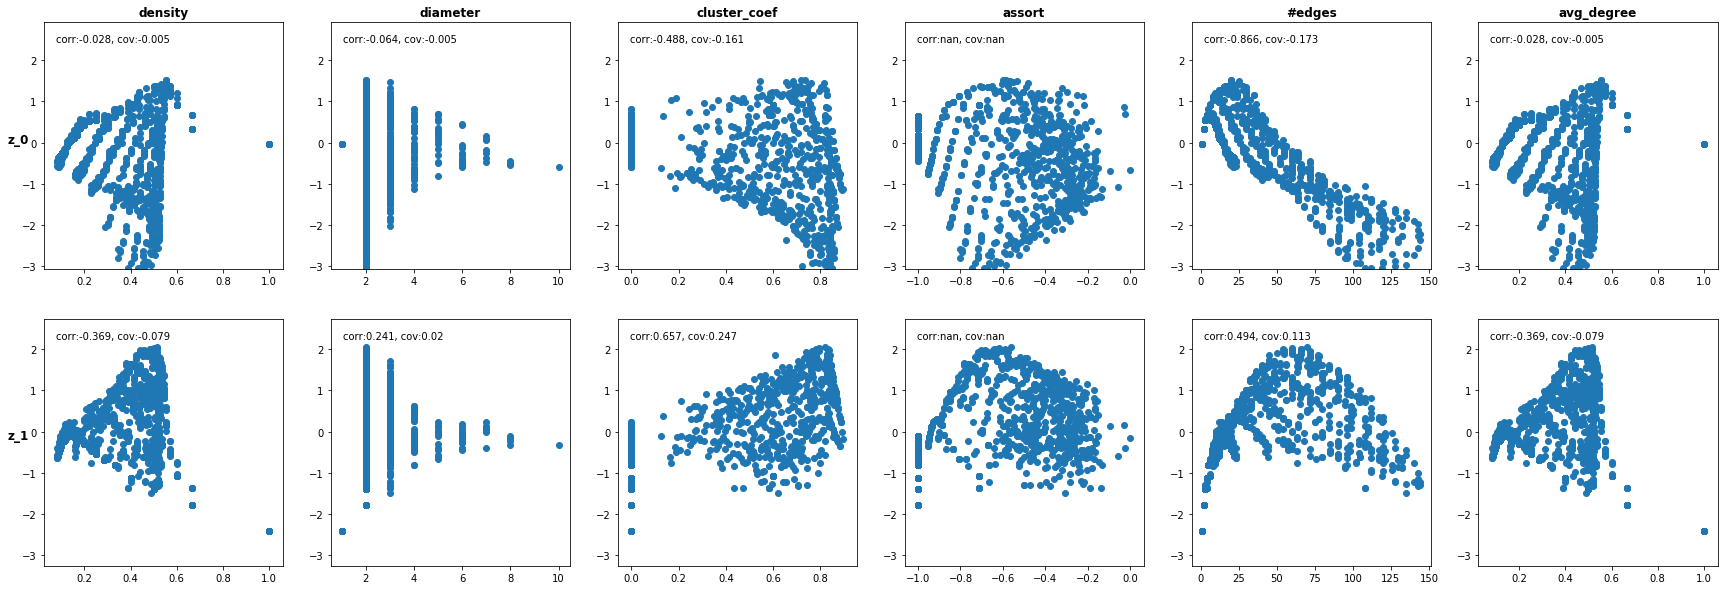

In [87]:
def latent_space_feature_correlation(analyzeArgs, modelArgs, models,batch_size=128,model_name="vae_graph"):

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models

    
    if analyzeArgs["root_params"] == 1 or modelArgs["latent_dim"] == 1:
        
        ## Generate Graph Data_______________________________
        
        n = dataArgs["n_max"] 
        E = np.linspace(1, max(1, n - 1),analyzeArgs["n_config_graphs"], dtype=int)  # array 0.1, 0.2 - 1 / n_config_graphs  
        
        ## growth and topol parameters
        growth_topol_params = ["e","density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]
        
        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth_Topol = np.zeros((analyzeArgs["n_config_graphs"], len(growth_topol_params)))
    
        for i, e in enumerate(E):

            ## Generate Graph Type ______________________________________________

            g = get_graph(int(n), e, draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth_Topol[i,0] = e
            Growth_Topol[i,1] = density
            Growth_Topol[i,2] = diameter
            Growth_Topol[i,3] = cluster_coef
            Growth_Topol[i,4] = assort
            Growth_Topol[i,5] = edges
            Growth_Topol[i,6] = avg_degree

  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
        
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            mig = compute_mig(E, np.squeeze(z_mean))
            
        
        ## Visualize Latent Variables x Graph Properties ____________________________
        fig, ax = plt.subplots(nrows= z_mean.shape[1], ncols= Growth_Topol.shape[1], figsize=(20, 10))

        for latent_z, row in enumerate(ax):  
            
            if z_mean.shape[1] == 1:   # only one latent variable
                
                if latent_z == 0:
                    y = z_mean[:,0]
                    x = Growth_Topol[:,latent_z]
                    row.plot(x, y) 

                else:
                    y = z_mean[:,0]
                    x = Growth_Topol[:,latent_z]
                    #row.scatter(x, y) 
                    sns.regplot(x, y, color="steelblue", ax=row)

                    ## plot trend line
                    #x = np.nan_to_num(x)
                    #y = np.nan_to_num(y)

                    #z = np.polyfit(x, y, 1)
                    #p = np.poly1d(z)
                    #row.plot(x,p(x),"steelblue")
                    
                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                row.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')

                    
            else:                     # multiple latent variables
                
                for feature, col in enumerate(row):

                    if feature == 0:
                        y = z_mean[:,latent_z]
                        x = Growth_Topol[:,feature]
                        col.plot(x, y) 

                    else:
                        y = z_mean[:,latent_z]
                        x = Growth_Topol[:,feature]
                        #col.scatter(x, y) 
                        sns.regplot(x, y, color="steelblue", ax=col)

                        ## plot trend line
                        #x = np.nan_to_num(x)
                        #y = np.nan_to_num(y)

                        #z = np.polyfit(x, y, 1)
                        #p = np.poly1d(z)
                        #col.plot(x,p(x),"steelblue")
            
                
                    ## compute correlation and standardized covariance
                    corr = round(pearsonr(x,y)[0],3)
                    cov = round(np.cov(x, y)[0][1]/max(x),3)
                    col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________
        
        if z_mean.shape[1] == 1:   # only one latent variable
                
            cols = [t for t in growth_topol_params]
            
            for axis, col in zip(ax[:,], cols):
                axis.set_title(col, fontweight='bold')
                
        
        if z_mean.shape[1] != 1:   # more than one latent variable
            
            rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
            cols = [t for t in growth_topol_params]

            for axis, row in zip(ax[:,0], rows):
                axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')
            
            for axis, col in zip(ax[0], cols):
                axis.set_title(col, fontweight='bold')

        plt.show()
        
    
    
    
    if analyzeArgs["root_params"] == 2:
        
        ## Generate Graph Data_______________________________
    
        N = np.linspace(2,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype=int)  # array 1,2,3,4,5 - n_max / n_config_graphs
        E = np.linspace(1, max(1, dataArgs["n_max"]),analyzeArgs["n_config_graphs"], dtype=int)  # array 0.1, 0.2 - 1 / n_config_graphs 
        
        ## growth and topol parameters
        growth_params = ["e", "n"]
        topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(growth_params)))
        Topol = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(topol_params)))

        ## iterate through topological features
        graph_configs = np.asarray(list(itertools.product(E,N)))
        

        for i, (e,n) in enumerate(graph_configs):

            ## Generate Graph Type ______________________________________________
            try:
                g = get_graph(int(n), e, draw = False)
            except:
                g = get_graph(int(n), int(n)-1, draw = False)
                                
            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth[i,0] = e
            Growth[i,1] = int(n)

            Topol[i,0] = density
            Topol[i,1] = diameter
            Topol[i,2] = cluster_coef
            Topol[i,3] = assort
            Topol[i,4] = edges
            Topol[i,5] = avg_degree
  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
                
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            #mi = compute_mi(P, np.squeeze(z_mean))
            mig = compute_mig(Growth, z_mean)
        
        
        ##  Reshape Array according to Parameters  
        z_mean_growth = np.reshape(z_mean, (analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
        Growth = np.reshape(Growth,(analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
            
        ## 1.) Growth Parameters________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        fig, ax = plt.subplots(nrows= z_mean_growth.shape[-1] , ncols= len(growth_params))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                if feature == 0:
                    feature_1 = 1
                if feature == 1:
                    feature_1 = 0

                y = np.mean(z_mean_growth[:,:,latent_z], axis= feature_1)
                x = np.mean(Growth[:,:,feature], axis= feature_1)
                col.plot(x, y)
                col.set_ylim([np.mean(y) - 3.0, np.mean(y) + 3.0])

                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')


        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean_growth.shape[-1])]
        cols = [t for t in growth_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



        ## 2.) Graph Topologies________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        ##  Reshape Array according to Parameters  
        #Topol = np.reshape(Topol,(n_config_graphs, n_config_graphs, -1))

        fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= len(topol_params), figsize=(30,10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                ## toDO: change sorting
                y = z_mean[:,latent_z]
                x = Topol[:,feature]
                #sns.regplot(x, y, color="steelblue", ax=col)
                col.scatter(x, y) 
                col.set_ylim([np.mean(y) - 3.0, np.mean(y) + 3.0])

                # set axes range
                #plt.xlim(-4, 4)
                #plt.ylim(-4, 4)

               # try:
               #     ## plot trend line
               #     x = np.nan_to_num(x)
               #     y = np.nan_to_num(y)

               #     z = np.polyfit(x, y, 1)
               #     p = np.poly1d(z)
               #     col.plot(x,p(x),"steelblue")
               # except:
               #     pass


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')




## PLOT RESULTS ________________________________________

analyzeArgs = {"root_params": 2, "n_config_graphs": 10, "metric": "mig"}
latent_space_feature_correlation(analyzeArgs, modelArgs, models, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize the Latent Space in 2D

In [ ]:
analyzeArgs = {"save_plots": False}
vis2D(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

In [ ]:
analyzeArgs = {"z": [0,1]}
visDistr(modelArgs, analyzeArgs, models,data,trainArgs["batch_size"])

# Decoder

## Generate a Single Graph Instance

In [ ]:
analyzeArgs = {"activations": [0, 0.2], "z": [0,1]}
generate_single(analyzeArgs, modelArgs, dataArgs, models, color_map)

## Generate Interpolated Manifold from Latent Space

latent dimensions: 2


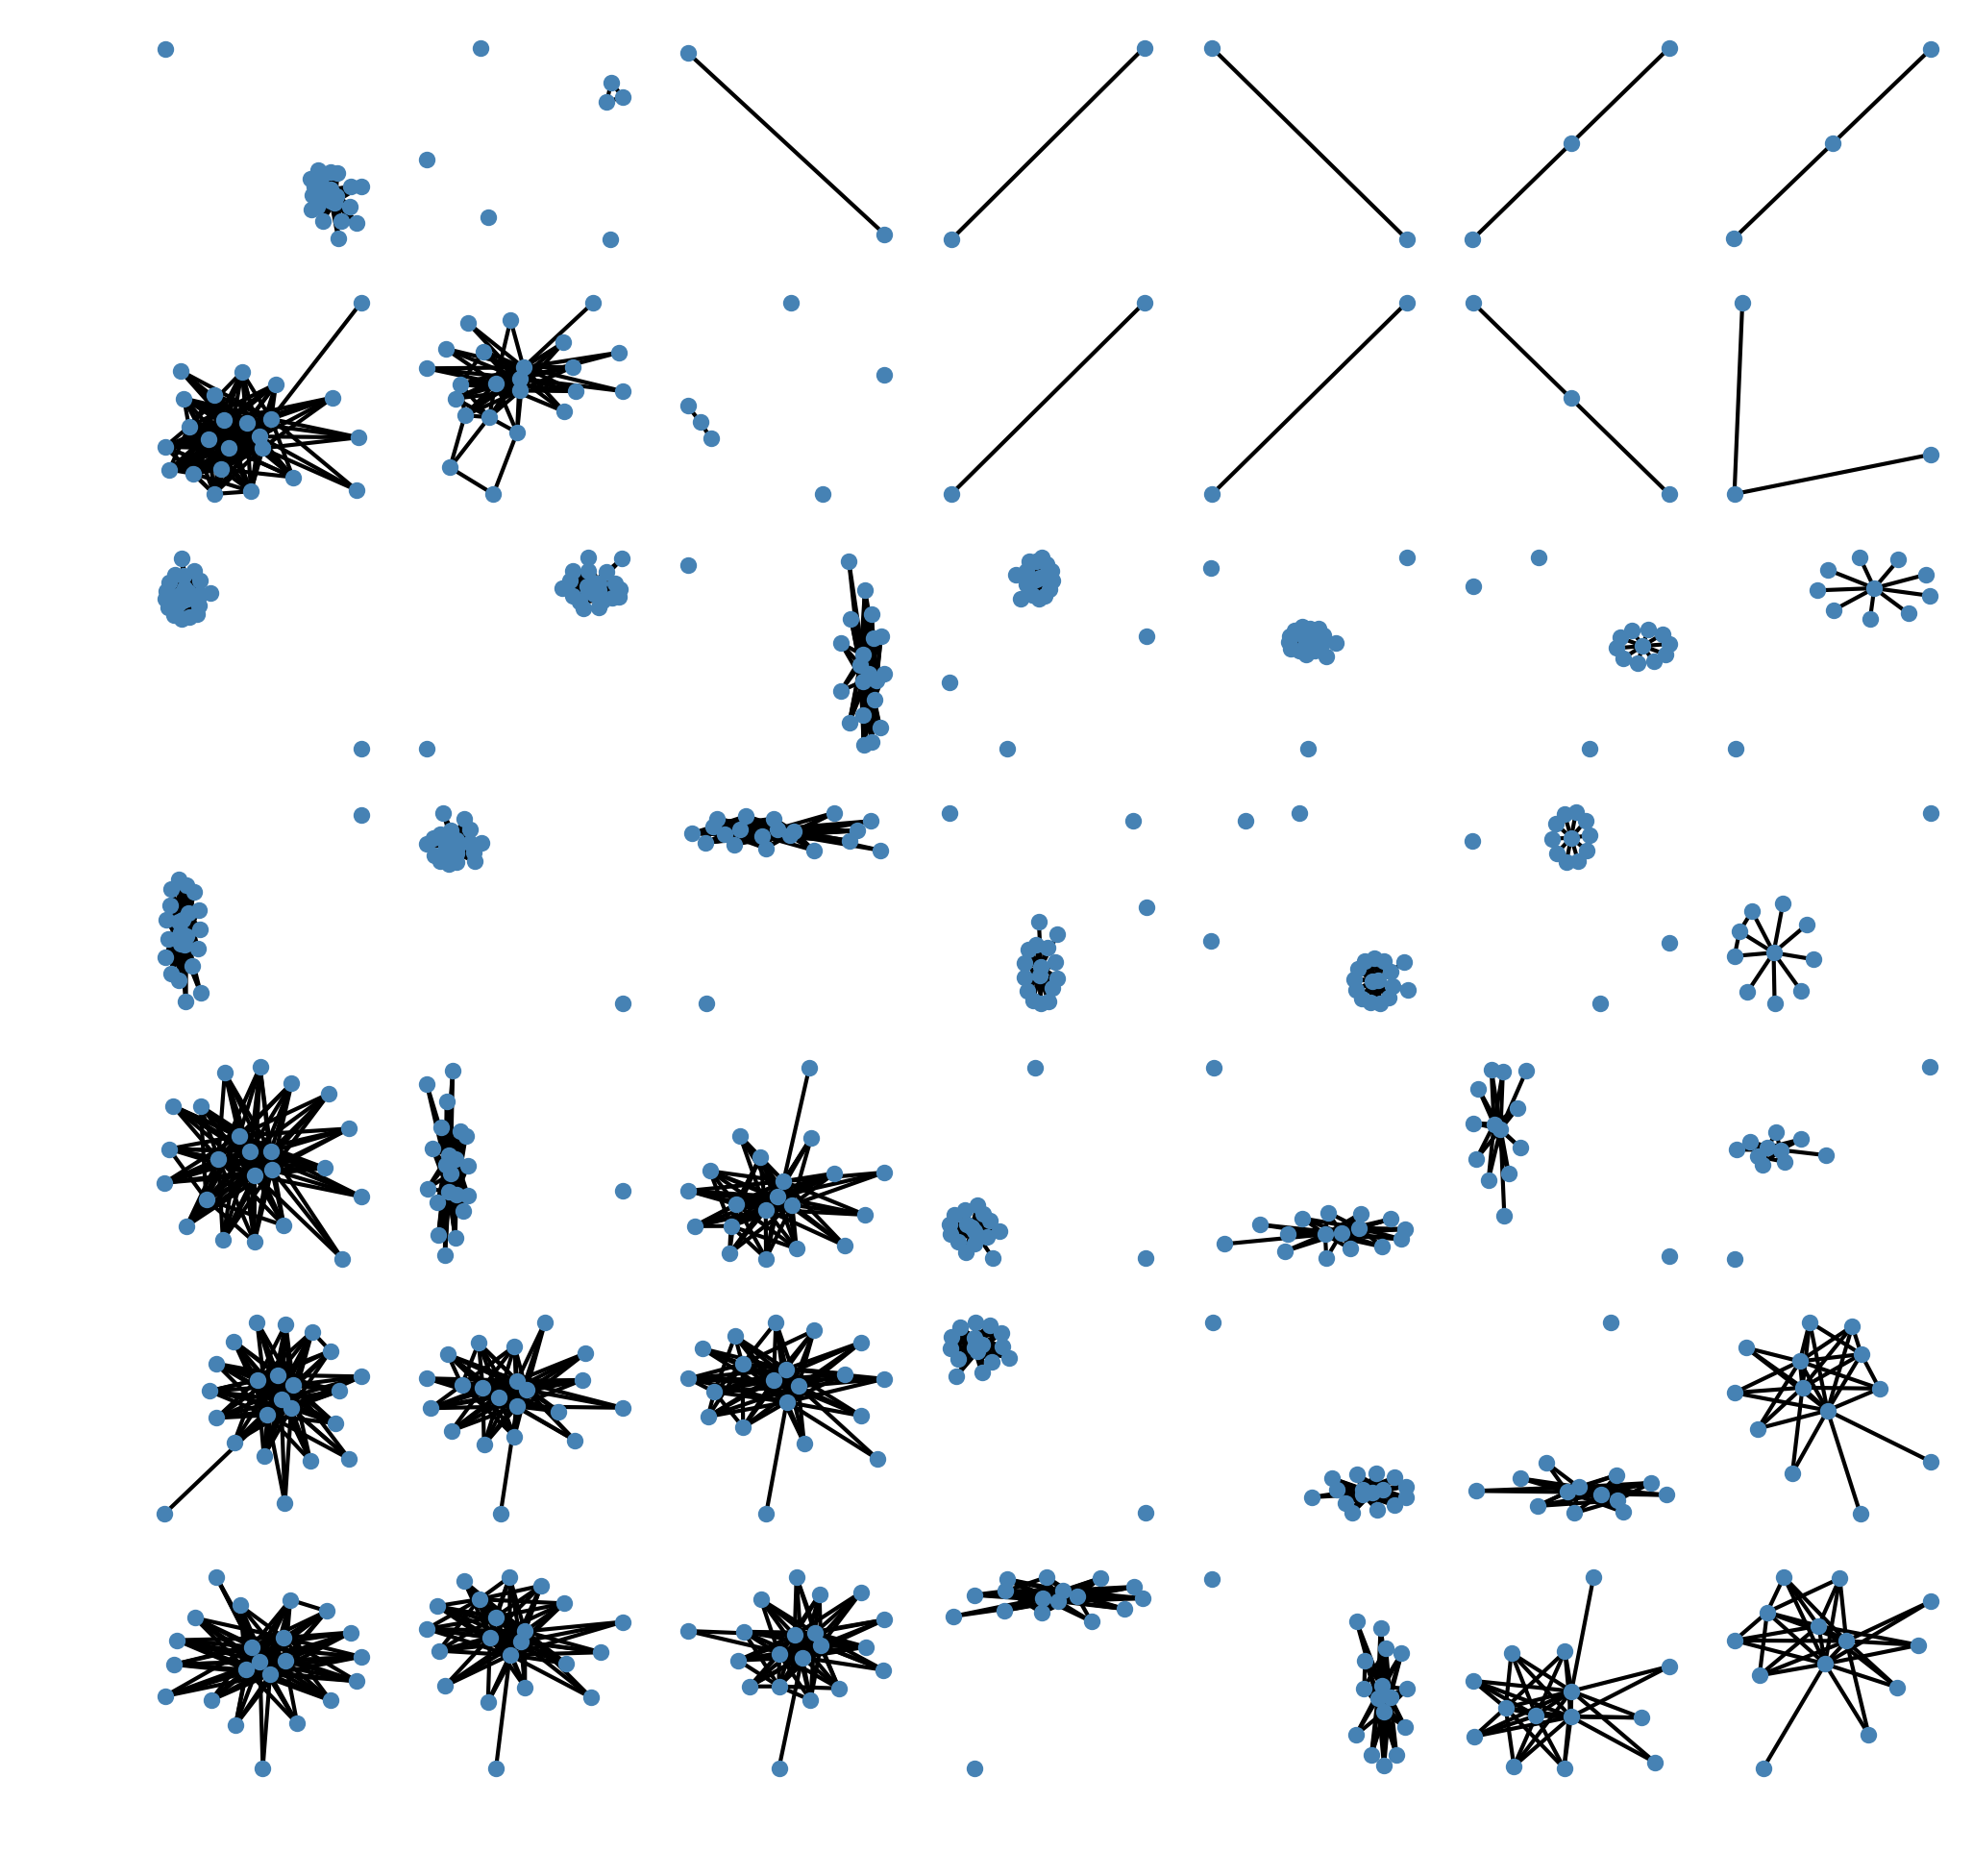

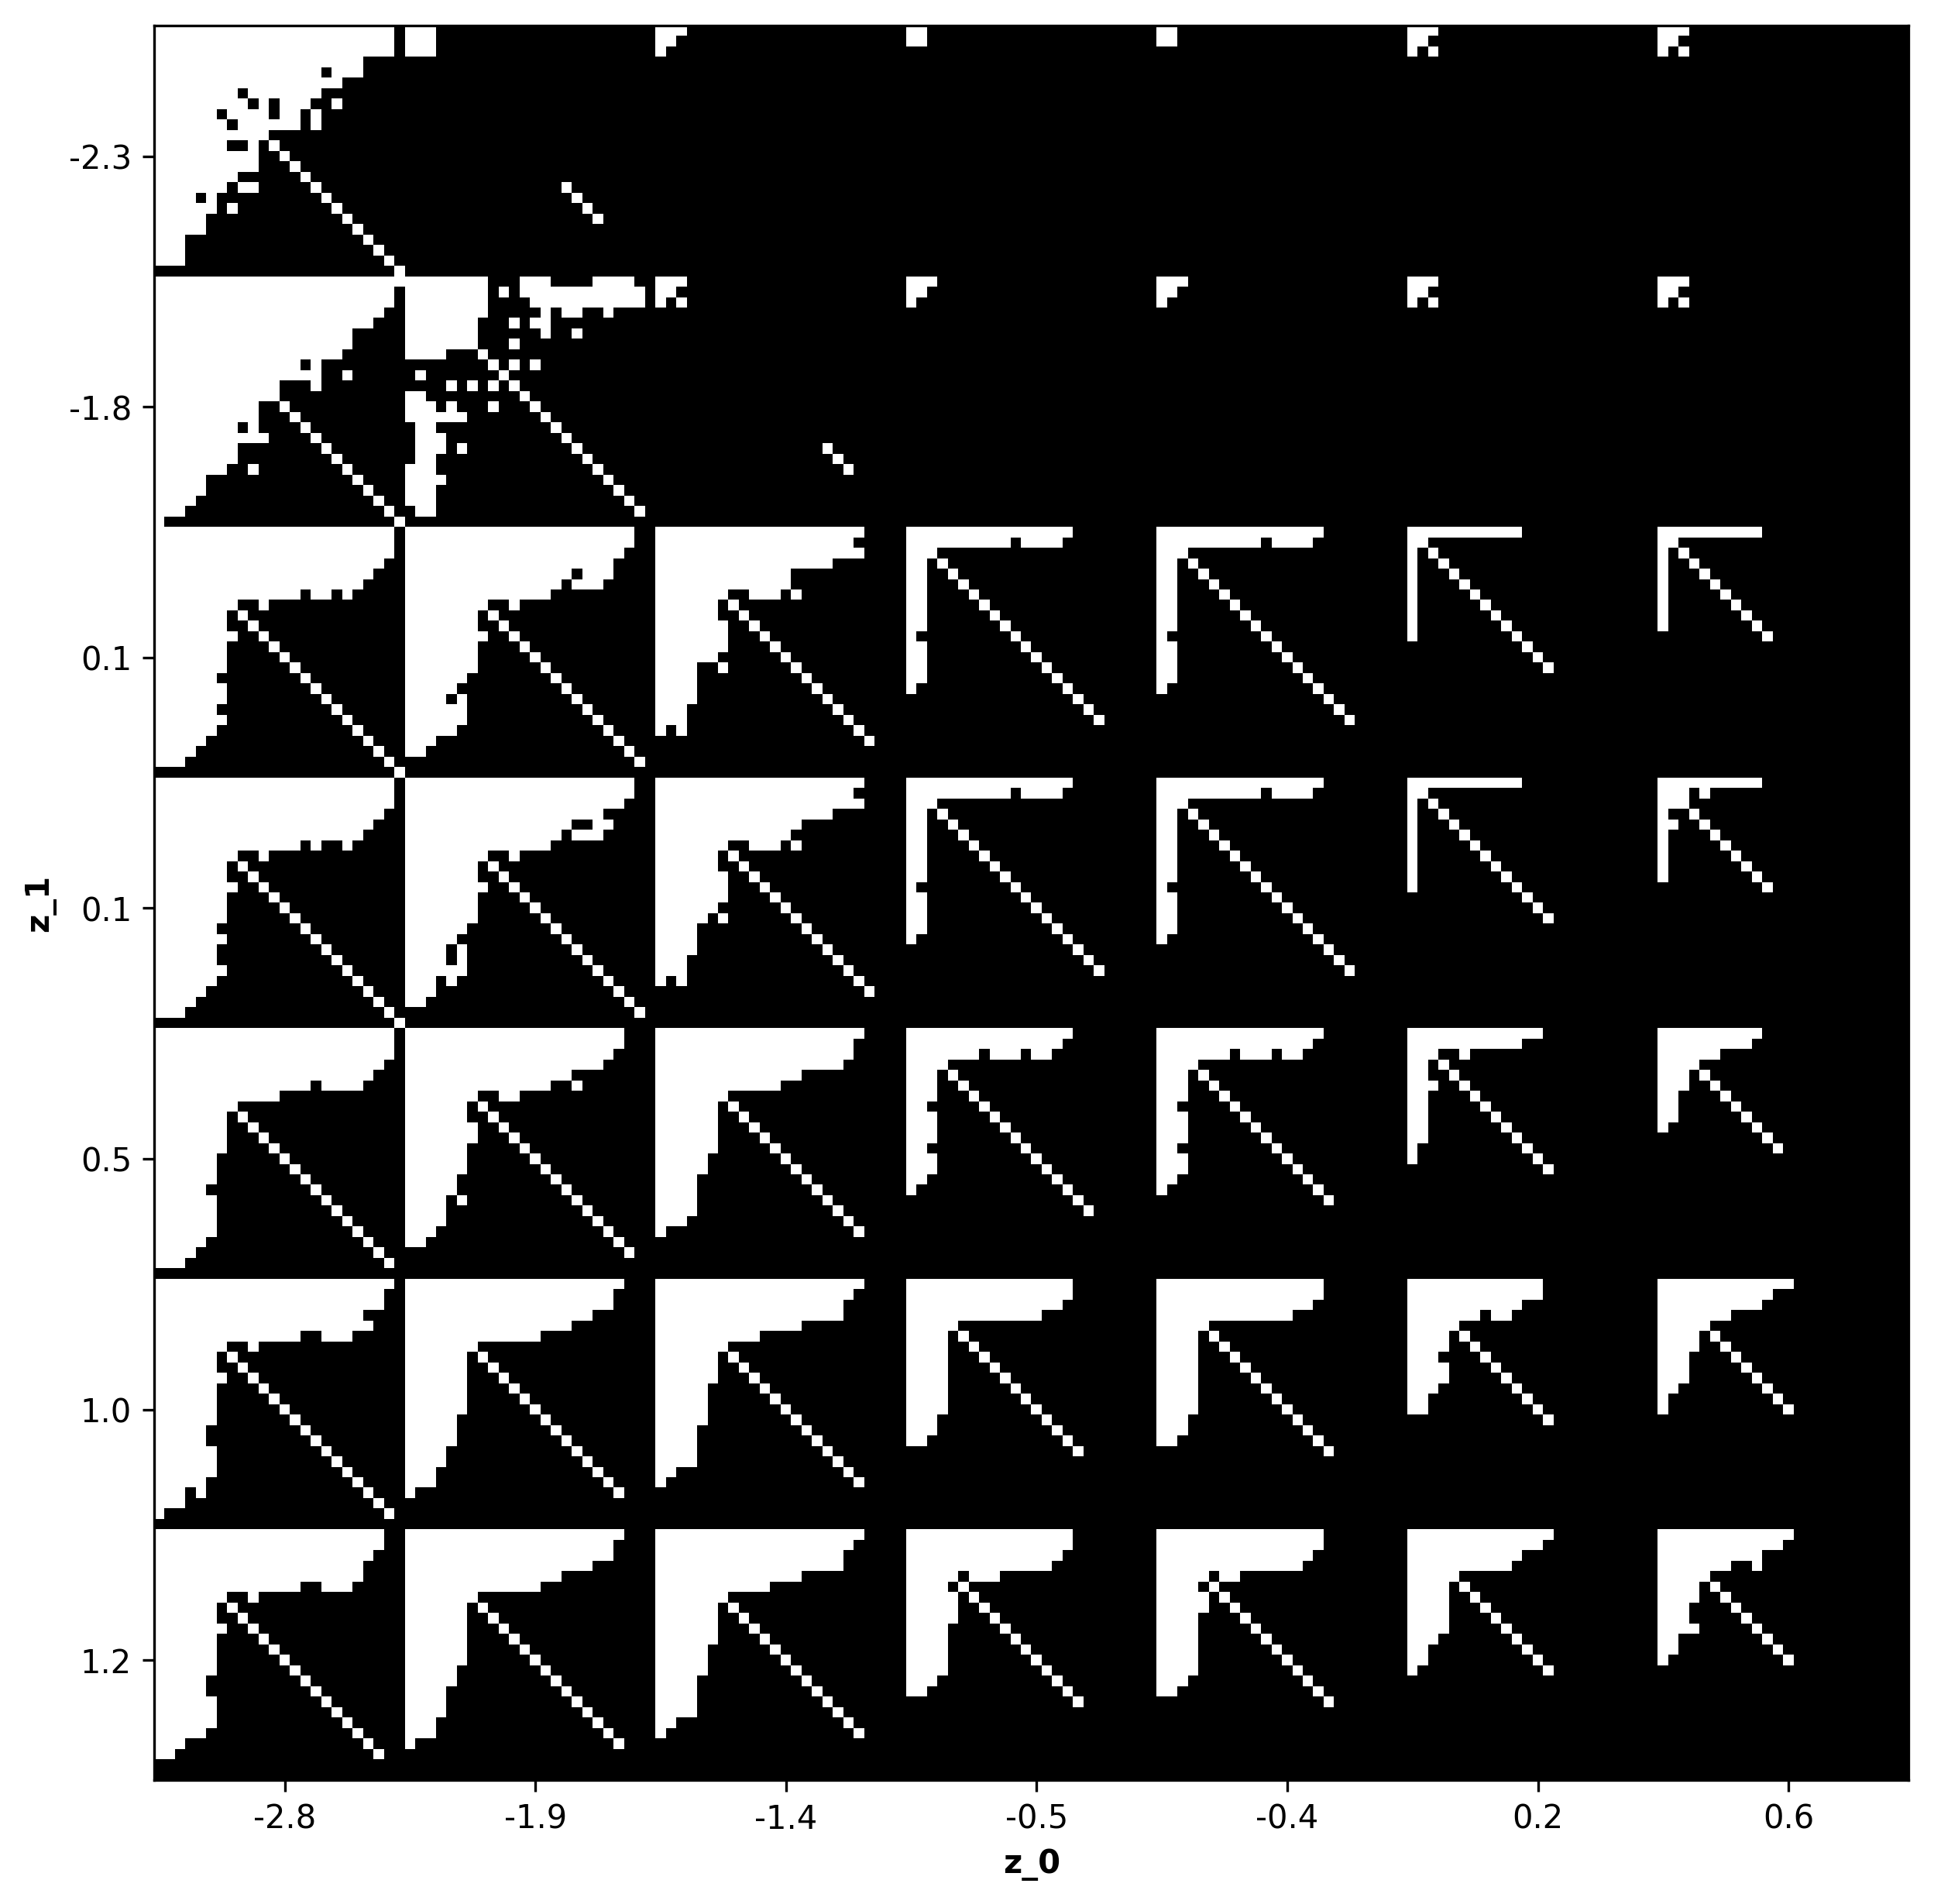

In [93]:
# range, normal, z

analyzeArgs = {"z": [0,1], "sample": "normal", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 7, "save_plots": False}
generate_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

In [ ]:
#### analyzeArgs = {"z": [0,1], "plot": "distr", "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

## "density", "cluster_coef", "assort", "avg_degree"

## Analyze Parameter Encoding

latent dimensions: 2
23 1
1.15 0.05263157894736842
23 3
1.15 0.15789473684210525
23 6
1.15 0.3157894736842105
23 8
1.15 0.42105263157894735
23 11
1.15 0.5789473684210527
23 13
1.15 0.6842105263157895
23 16
1.15 0.8421052631578947
23 18
1.15 0.9473684210526315
23 21
1.15 1.105263157894737
23 22
1.15 1.1578947368421053
21 1
1.05 0.05263157894736842
21 3
1.05 0.15789473684210525
21 6
1.05 0.3157894736842105
21 8
1.05 0.42105263157894735
21 11
1.05 0.5789473684210527
21 13
1.05 0.6842105263157895
21 16
1.05 0.8421052631578947
21 18
1.05 0.9473684210526315
21 20
1.05 1.0526315789473684
21 20
1.05 1.0526315789473684
18 1
0.9 0.05263157894736842
18 3
0.9 0.15789473684210525
18 6
0.9 0.3157894736842105
18 8
0.9 0.42105263157894735
18 11
0.9 0.5789473684210527
18 13
0.9 0.6842105263157895
18 16
0.9 0.8421052631578947
18 17
0.9 0.8947368421052632
18 17
0.9 0.8947368421052632
18 17
0.9 0.8947368421052632
16 1
0.8 0.05263157894736842
16 3
0.8 0.15789473684210525
16 6
0.8 0.3157894736842105
16 8
0.

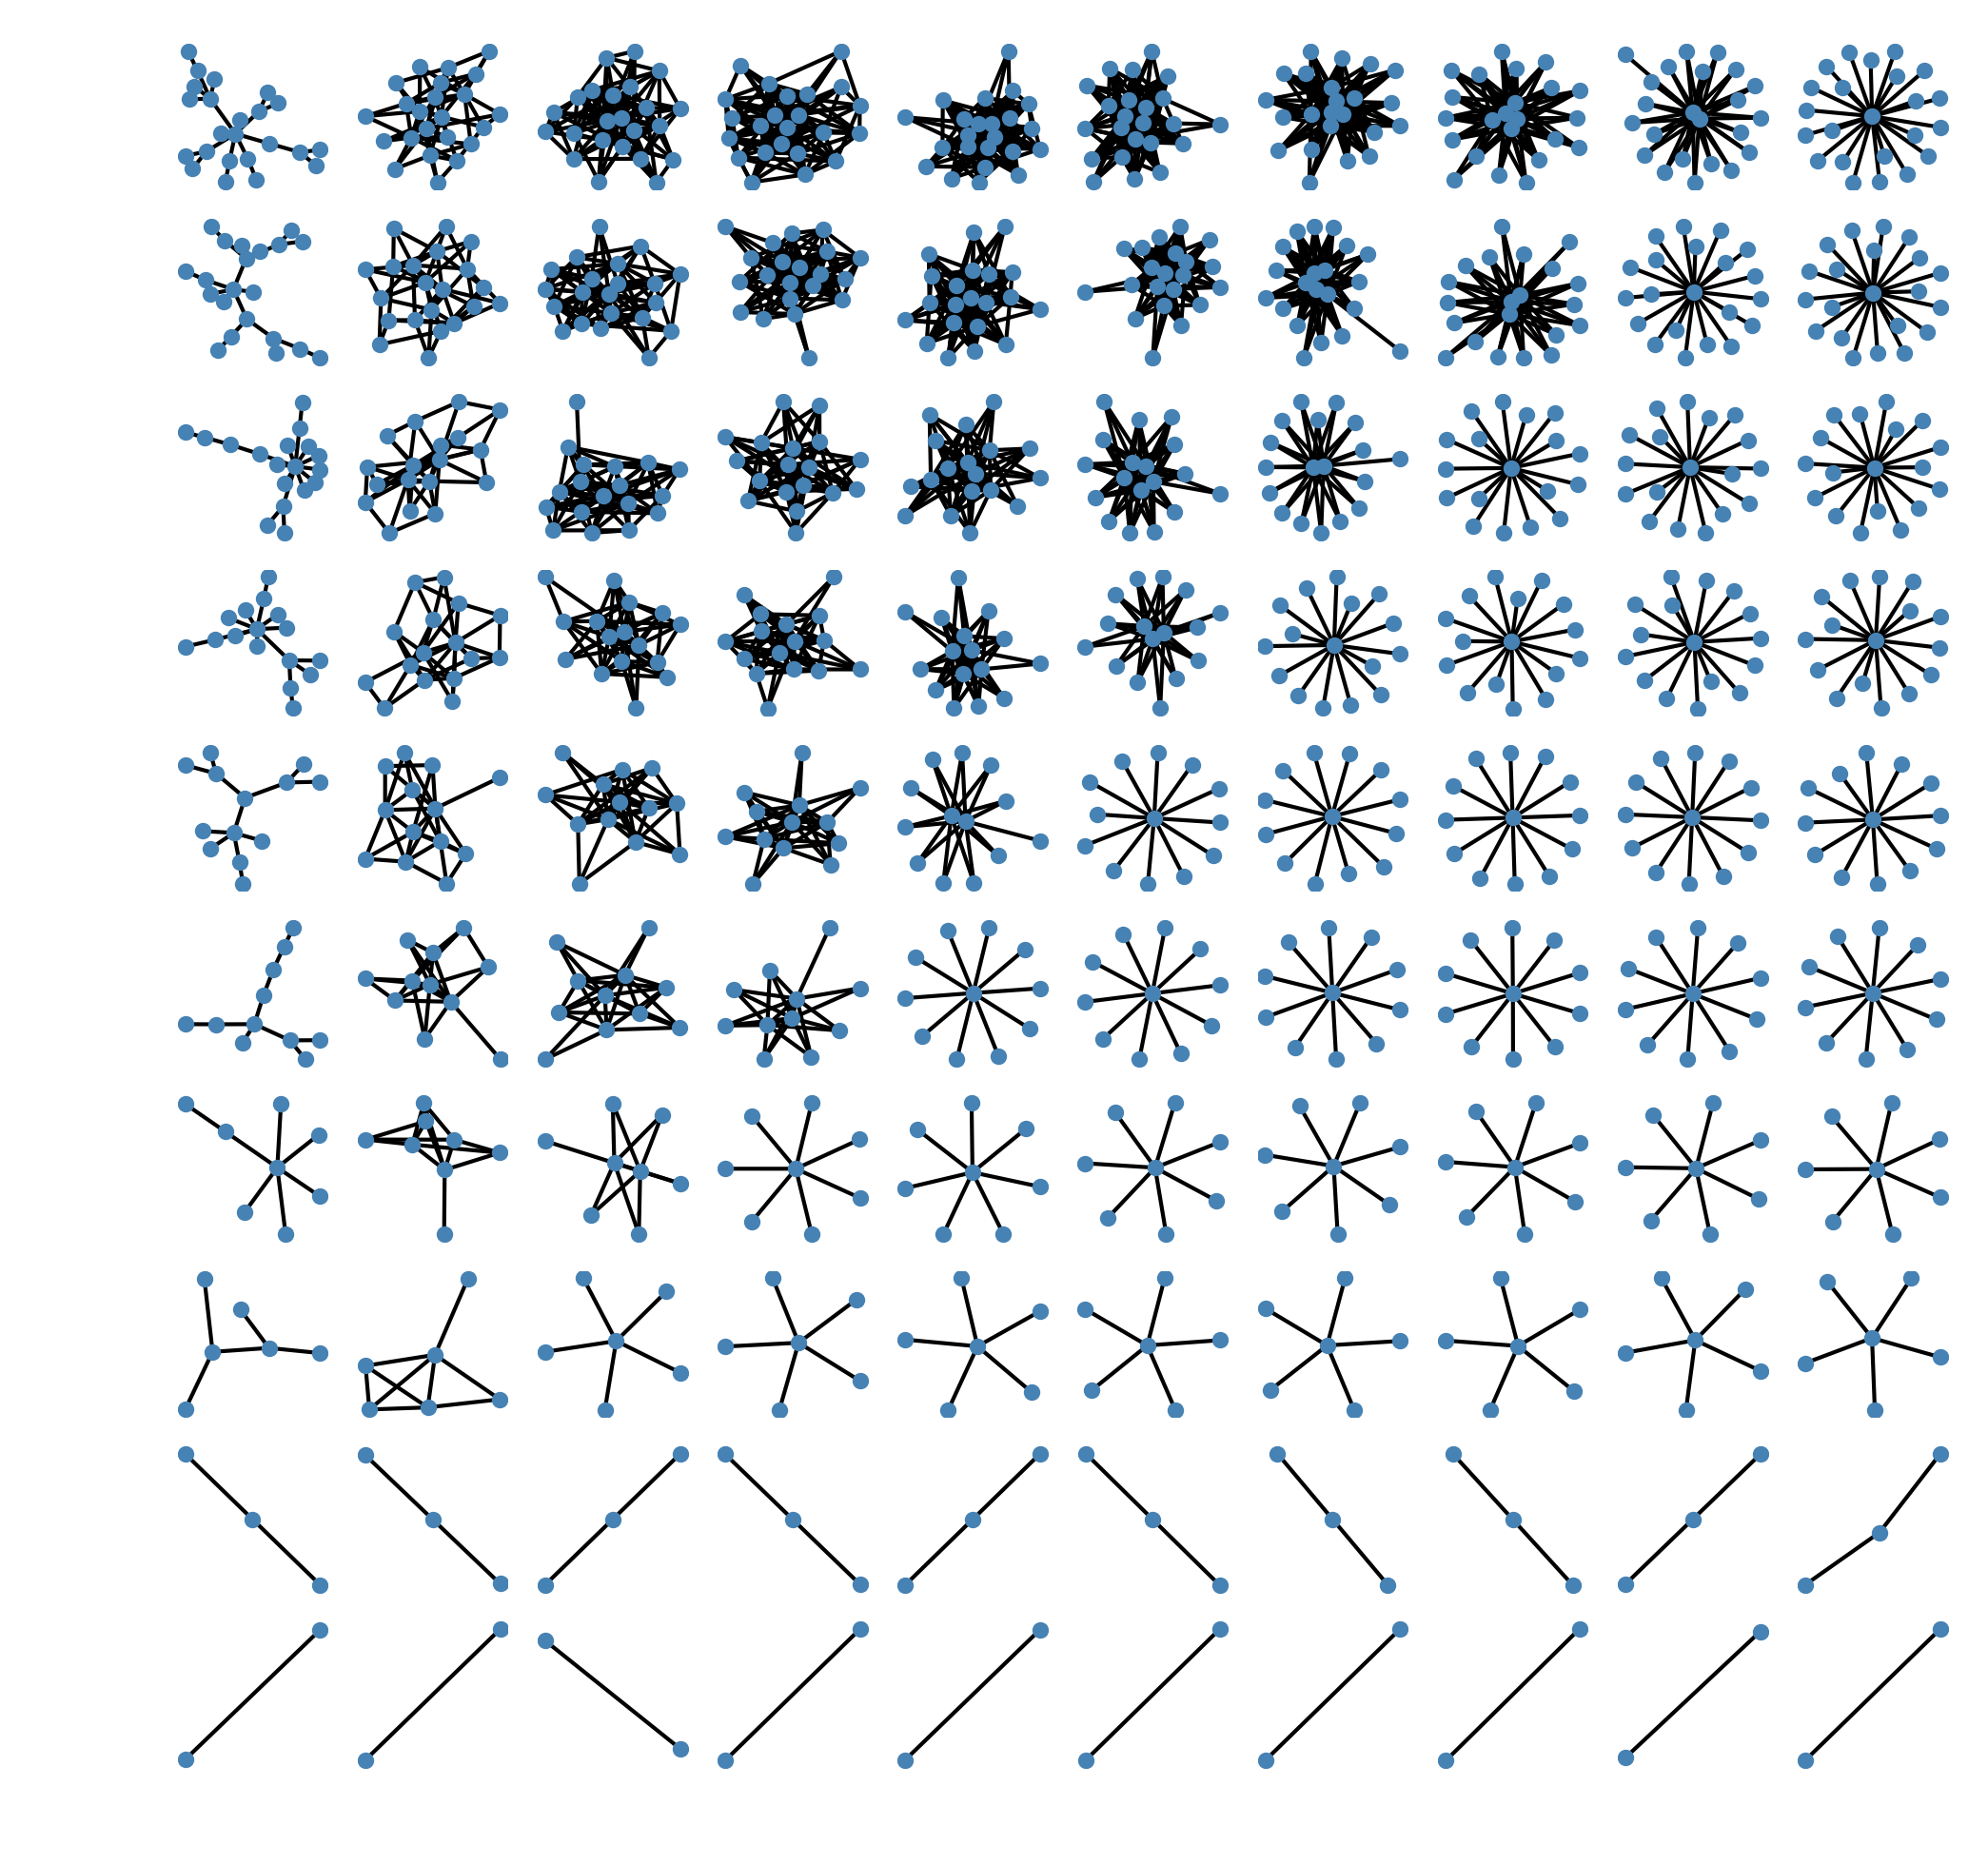

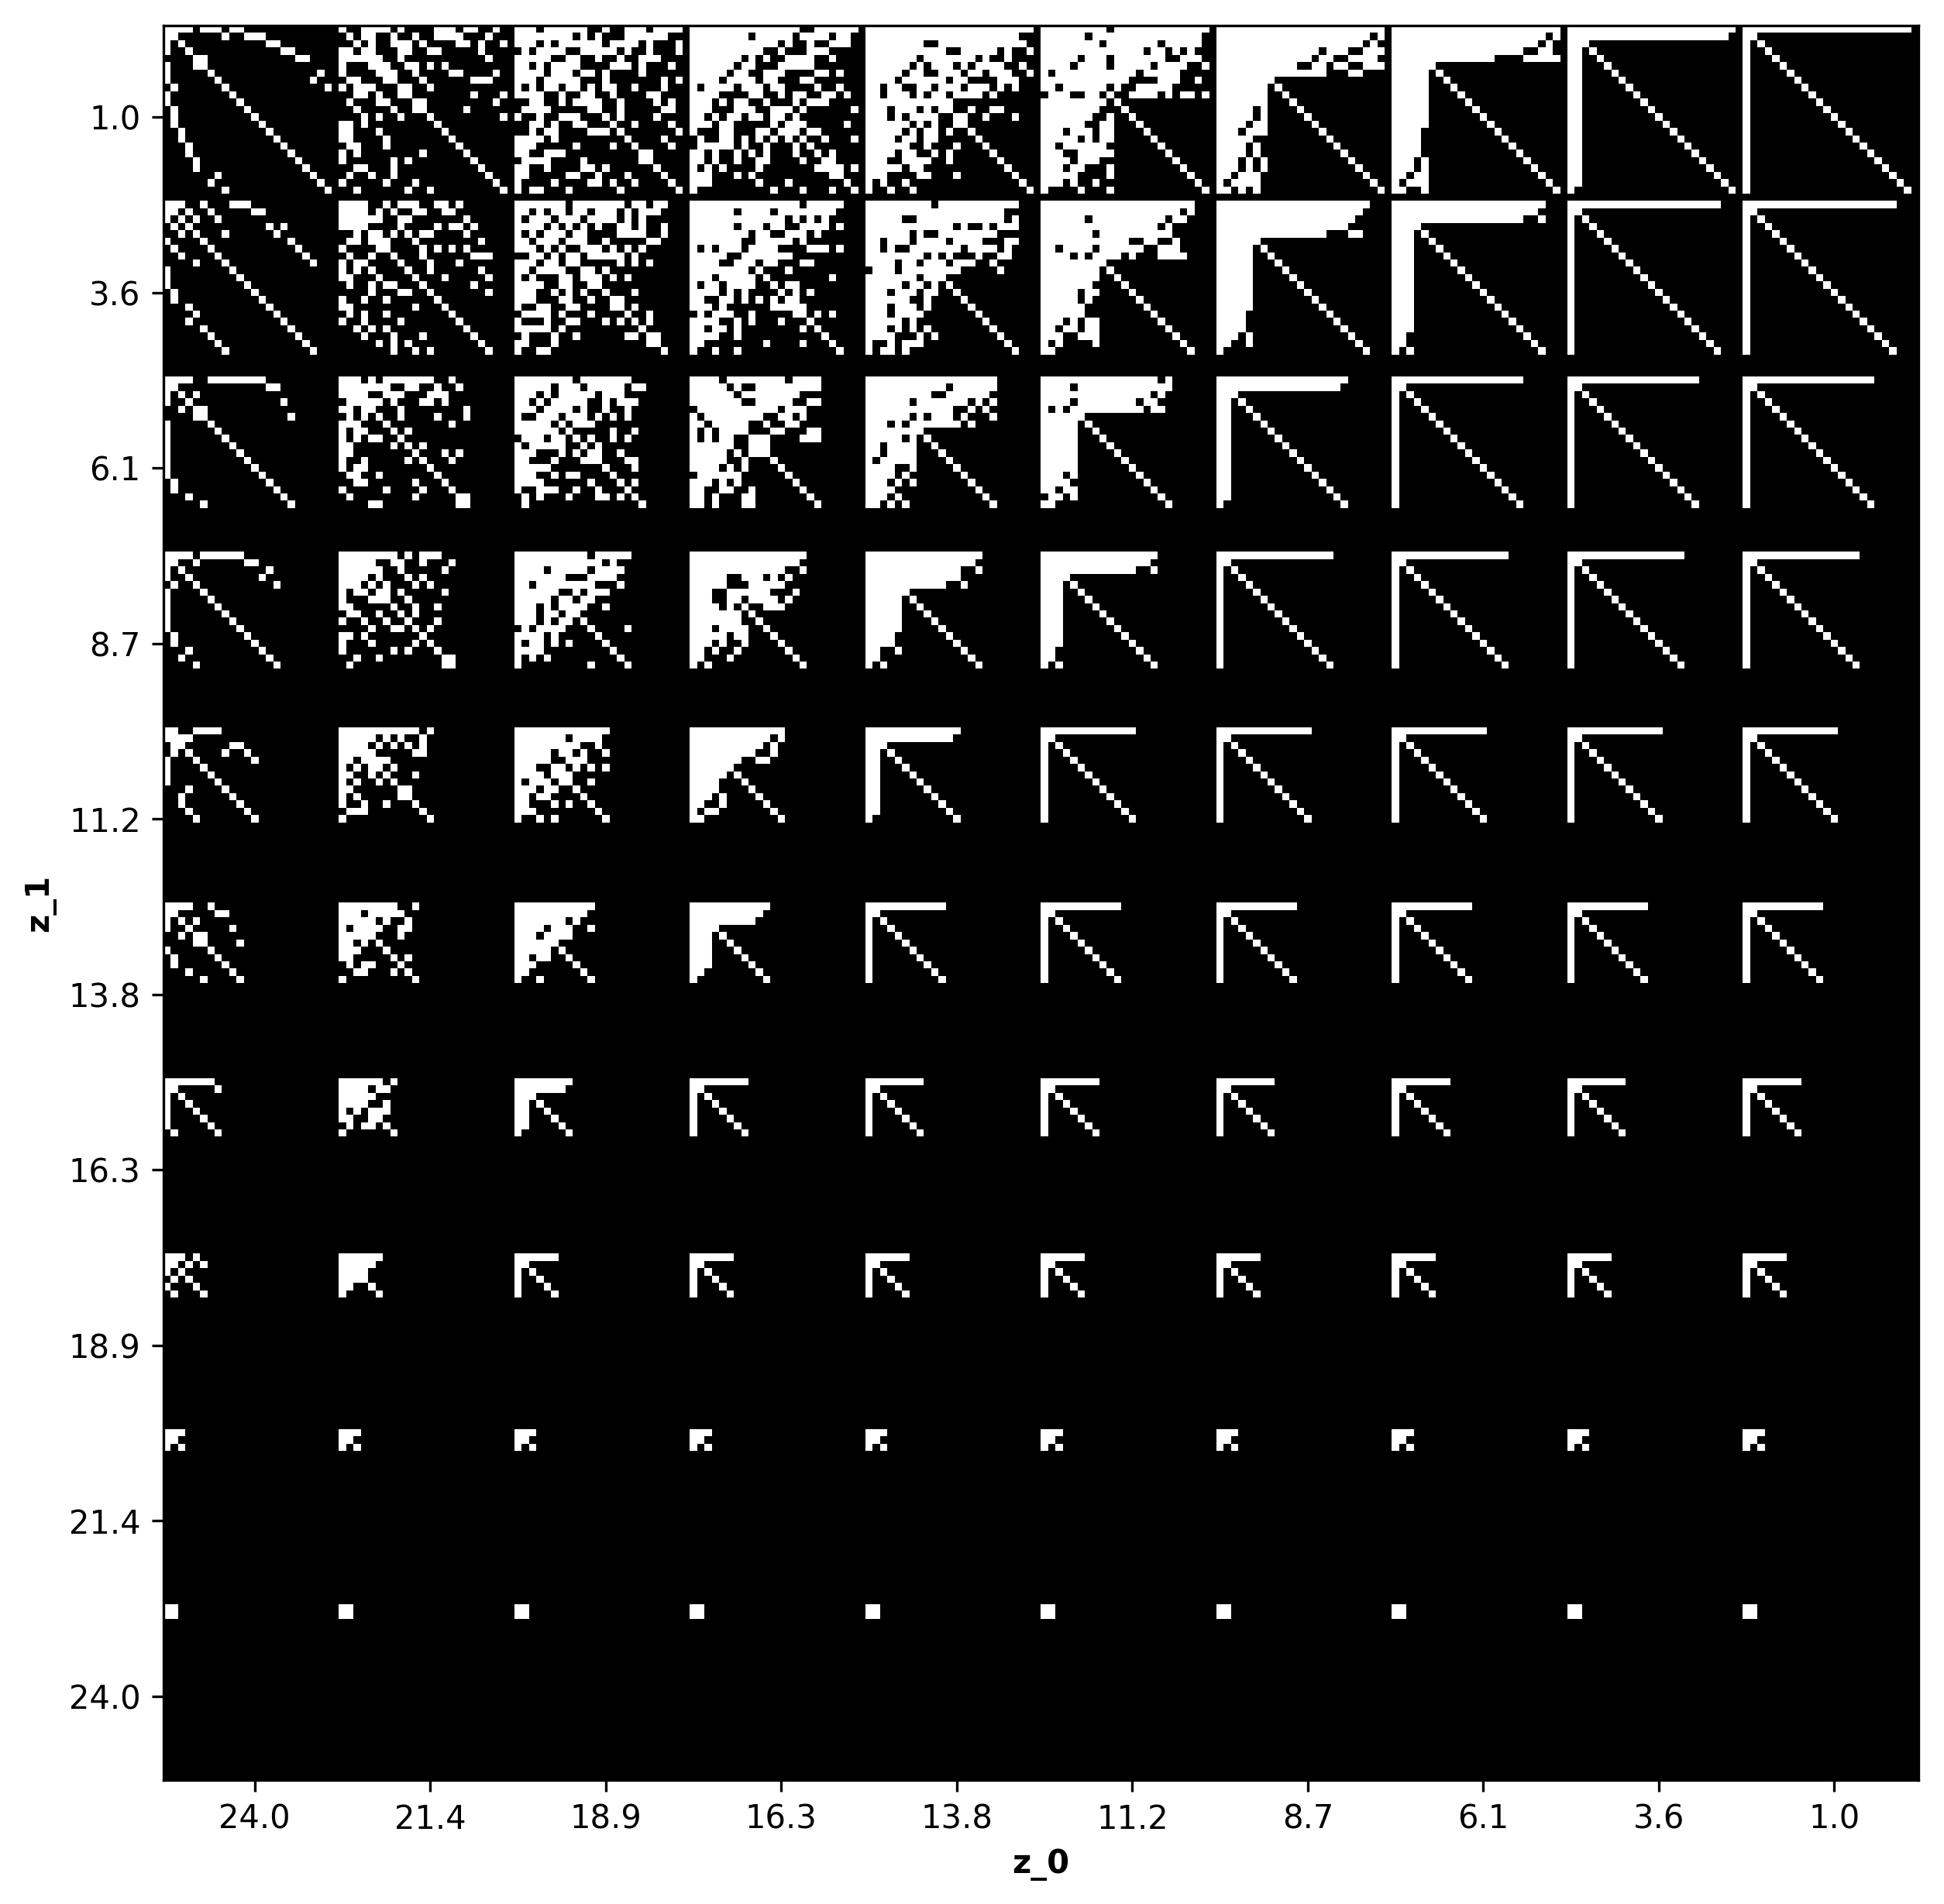

In [51]:
## range, normal, z
analyzeArgs = {"z": [0,1], "graph_type": "PA", "sample": "fake", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_param_graph_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)

## "cluster_coef", "assort", "avg_degree"

In [52]:
from support.preprocessing import reconstruct_adjacency, unpad_matrix, sort_adjacency, pad_matrix

import sys
import networkx as nx
from networkx.generators import random_graphs
from networkx.generators import classic
import numpy as np

from matplotlib import pylab as plt
import os



def decode_param(analyzeArgs, dataArgs, scaler, x_decoded):
    ## generate graph from generative parameters
    #x_decoded = scaler.inverse_transform(x_decoded)
    #x_decoded = np.squeeze(x_decoded)

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "Complete":
        n_gen = np.clip(int(x_decoded), 1, dataArgs["n_max"] - 1)
        g = classic.complete_graph(n_gen)

        params = ("n")
        y_pos = np.arange(len(params))
        param_values = [n_gen / dataArgs["n_max"]]

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "Tree":
        b_gen = np.clip(int(x_decoded[0]), 1, dataArgs["n_max"] - 1)
        h_gen = np.clip(int(x_decoded[1]), 1, dataArgs["n_max"] - 1)
        g = classic.balanced_tree(b_gen, h_gen)

        params = ("b", "h")
        y_pos = np.arange(len(params))
        param_values = [b_gen, h_gen]

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "ER":
        n_gen = np.clip(int(x_decoded[0]), 1, dataArgs["n_max"] - 1)
        p_gen = np.clip(x_decoded[1], 0, 1)
        g = random_graphs.erdos_renyi_graph(n_gen, p_gen, seed=None, directed=False)

        params = ("n", "p")
        y_pos = np.arange(len(params))
        param_values = [n_gen / dataArgs["n_max"], p_gen]

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "PA":
        n_gen = np.clip(int(x_decoded[0]), 2, dataArgs["n_max"] - 1)
        e_gen = np.clip(int(x_decoded[1]), 1, n_gen - 1)
        g = random_graphs.barabasi_albert_graph(n_gen, e_gen, seed=None)

        print(n_gen, e_gen)
        params = ("n", "e")
        y_pos = np.arange(len(params))
        param_values = [n_gen / 20, e_gen / 19]
        
        print(n_gen / 20, e_gen / 19)

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "HK":
        n_gen = np.clip(int(x_decoded[0]), 1, dataArgs["n_max"] - 1)
        e_gen = np.clip(int(x_decoded[1]), 1, n_gen)
        p_gen = np.clip(x_decoded[2], 0, 1)
        g = random_graphs.powerlaw_cluster_graph(n_gen, e_gen, p_gen, seed=None)

        params = ("n", "e", "p")
        y_pos = np.arange(len(params))
        param_values = [n_gen / dataArgs["n_max"], e_gen / n_gen, p_gen]

        return g, y_pos, params, param_values

    ## ensure data matches range
    if analyzeArgs["graph_type"] == "SW":
        n_gen = np.clip(int(x_decoded[0]), 1, dataArgs["n_max"] - 1)
        k_gen = np.clip(int(x_decoded[1]), 0, n_gen - 1)
        p_gen = np.clip(x_decoded[2], 0, 1)
        g = random_graphs.newman_watts_strogatz_graph(n_gen, k_gen, p_gen, seed=None)  # no edges are removed

        params = ("n", "k", "p")
        y_pos = np.arange(len(params))
        param_values = [n_gen / dataArgs["n_max"], k_gen / 19, p_gen]

        return g, y_pos, params, param_values



            
def generate_param_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size, scaler):
    print("latent dimensions:", modelArgs["latent_dim"])

    if modelArgs["param_loss"] == False:
        sys.exit("modelArgs[param_loss] should be True")
    else:
        encoder, graph_decoder, param_decoder = models  # trained models

    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)

    ## Latent Space Dimension is 1 ______________________

    if modelArgs["latent_dim"] == 1:

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))

        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

        ## 1) create graph topol plots_______________________________________________

        fig, axs = plt.subplots(1, analyzeArgs["size_of_manifold"], figsize=(10, 10))
        # fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()

        for j, xi in enumerate(grid_x):
            z_sample[0][0] = xi ** analyzeArgs["act_scale"]
            x_decoded = param_decoder.predict(z_sample)

            g, y_pos, params, param_values = decode_param(analyzeArgs, dataArgs, scaler, x_decoded)

            # compute index for the subplot, and set this subplot as current
            plt.sca(axs[j])

            ## create the plot_____________________________________________

            colors = ["midnightblue", "steelblue", "skyblue"]

            plt.bar(y_pos, param_values, color=colors, align='center')
            plt.plot([-1, 2], [0.25, 0.25], color='grey', linestyle='dashed')
            plt.plot([-1, 2], [0.5, 0.5], color='grey', linestyle='dashed')
            plt.plot([-1, 2], [0.75, 0.75], color='grey', linestyle='dashed')
            plt.xticks(y_pos, params)

            axs[xi].set_axis_off()

        # import matplotlib.patches as mpatches

        # density_patch = mpatches.Patch(color='midnightblue', label='density')
        # cluster_patch = mpatches.Patch(color='blue', label='cluster_coef')
        # assort_patch = mpatches.Patch(color='steelblue', label='assort')
        # avg_degree_patch = mpatches.Patch(color='skyblue', label='avg_degree')
        # axs[-1].legend(handles=[density_patch, cluster_patch, assort_patch, avg_degree_patch])

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)

    if modelArgs["latent_dim"] == 2:

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))
            
        elif analyzeArgs["sample"] == "fake":
            grid_x = np.linspace(1, 20,analyzeArgs["size_of_manifold"])[::-1]  ## revert
            grid_y = np.linspace(1, 19, analyzeArgs["size_of_manifold"])

        ## 1) create graph topol plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(8, 8), dpi = 300)
        # fig.subplots_adjust(hspace = .5, wspace=.001)

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                xi_value = xi ** analyzeArgs["act_scale"]
                yi_value = yi ** analyzeArgs["act_scale"]

                z_sample = np.array([[xi_value, yi_value]])
                x_decoded = param_decoder.predict(z_sample)

                g, y_pos, params, param_values = decode_param(analyzeArgs, dataArgs, scaler, [xi, yi])

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])

                ## create the plot_____________________________________________

                colors = ["midnightblue", "steelblue", "skyblue"]

                plt.bar(y_pos, param_values, color=colors, align='center')
                plt.plot([-1, 2], [0.25, 0.25], color='grey', linestyle='dashed')
                plt.plot([-1, 2], [0.5, 0.5], color='grey', linestyle='dashed')
                plt.plot([-1, 2], [0.75, 0.75], color='grey', linestyle='dashed')
                plt.xticks(y_pos, params)

                axs[i, j].set_axis_off()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)

    



latent dimensions: 2
20 1
1.0 0.05263157894736842
17 1
0.85 0.05263157894736842
15 1
0.75 0.05263157894736842
13 1
0.65 0.05263157894736842
11 1
0.55 0.05263157894736842
9 1
0.45 0.05263157894736842
7 1
0.35 0.05263157894736842
5 1
0.25 0.05263157894736842
3 1
0.15 0.05263157894736842
2 1
0.1 0.05263157894736842
20 3
1.0 0.15789473684210525
17 3
0.85 0.15789473684210525
15 3
0.75 0.15789473684210525
13 3
0.65 0.15789473684210525
11 3
0.55 0.15789473684210525
9 3
0.45 0.15789473684210525
7 3
0.35 0.15789473684210525
5 3
0.25 0.15789473684210525
3 2
0.15 0.10526315789473684
2 1
0.1 0.05263157894736842
20 5
1.0 0.2631578947368421
17 5
0.85 0.2631578947368421
15 5
0.75 0.2631578947368421
13 5
0.65 0.2631578947368421
11 5
0.55 0.2631578947368421
9 5
0.45 0.2631578947368421
7 5
0.35 0.2631578947368421
5 4
0.25 0.21052631578947367
3 2
0.15 0.10526315789473684
2 1
0.1 0.05263157894736842
20 7
1.0 0.3684210526315789
17 7
0.85 0.3684210526315789
15 7
0.75 0.3684210526315789
13 7
0.65 0.368421052

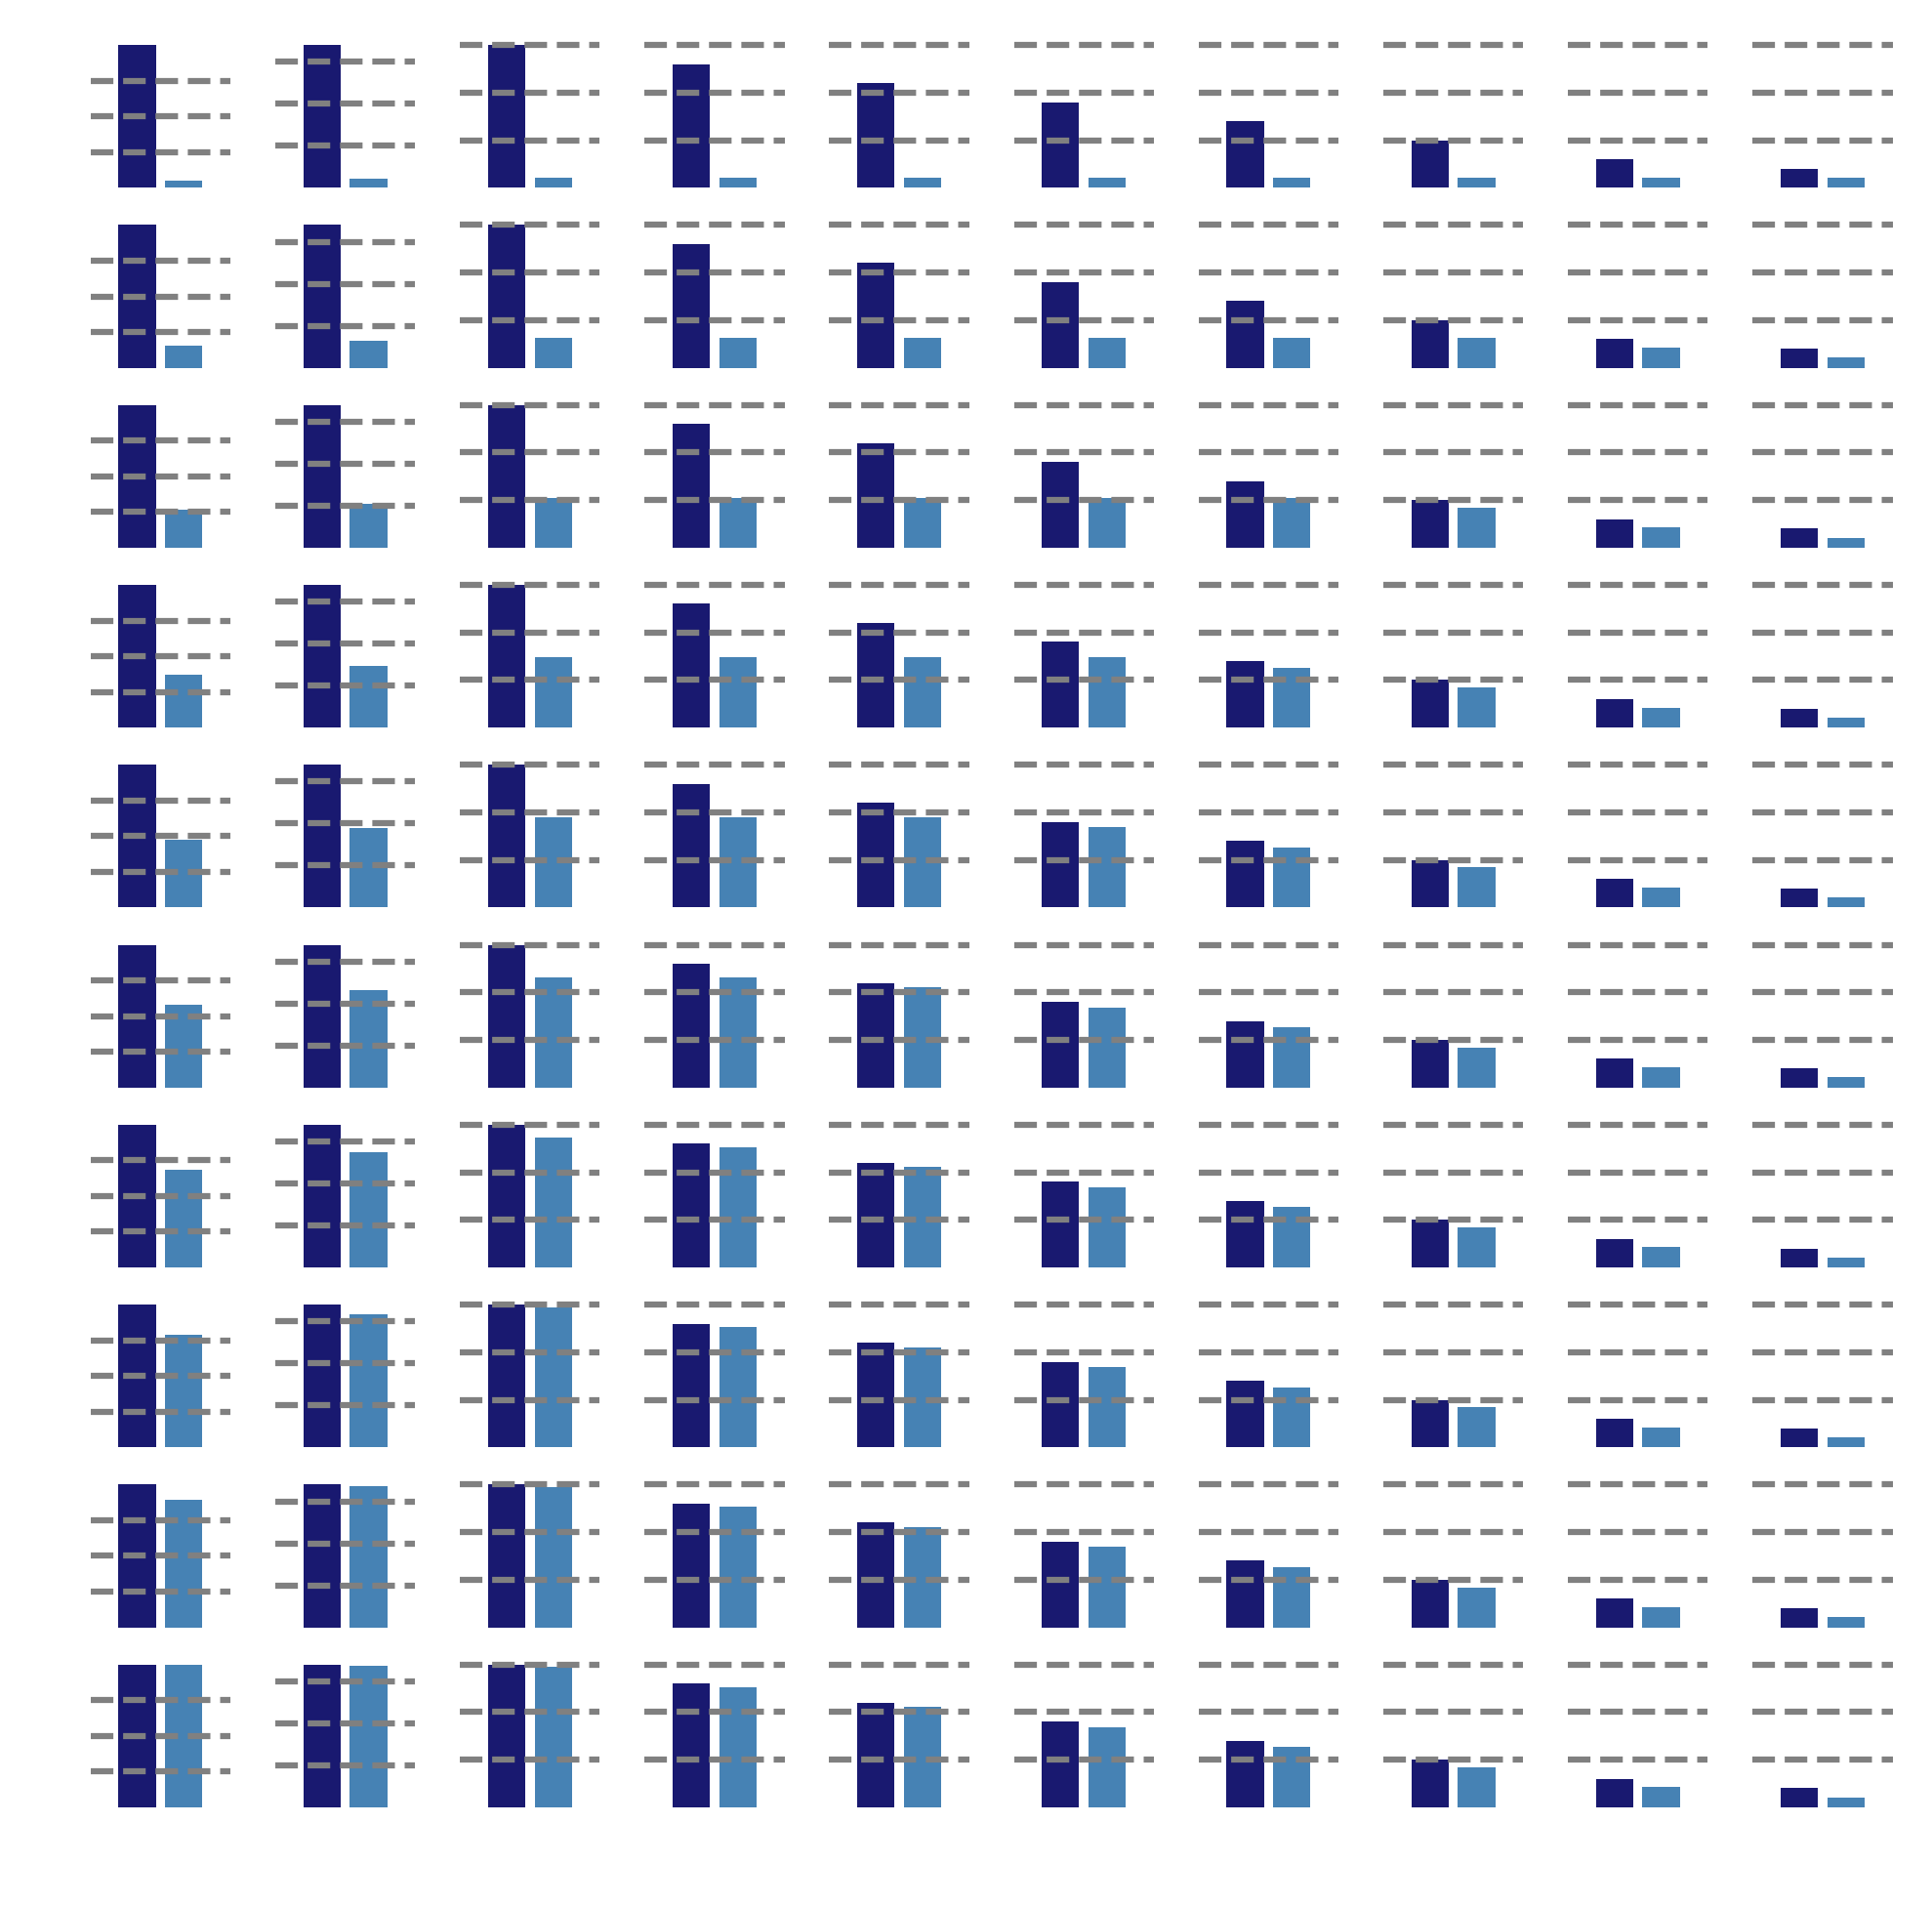

In [53]:
generate_param_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)